In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import email


def get_label_from_dirname(dirpath, positive_indicator="spam"):
    if positive_indicator in dirpath:
        return 1
    else:
        return 0 
    
# https://docs.python.org/2.4/lib/standard-encodings.html
def import_messages(root_dir="../data_sets/SpamAssassinMessages/", encoding="cp1256", positive_indicator="spam"):
    
    messages = {"message":[], "label":[], "foldername":[],
                "filename":[],"filepath":[]}
    
    for dirpath, dirnames, filenames in os.walk(root_dir, topdown=False):
        for name in filenames:
            fullpath = os.path.join(dirpath, name)
            messages['label'].append(get_label_from_dirname(dirpath=dirpath, positive_indicator=positive_indicator))
            messages['foldername'].append(os.path.basename(dirpath))
            messages['filepath'].append(fullpath)
            messages['filename'].append(name)
            with open(fullpath,'r', encoding=encoding) as f:
                try:
                    msg = email.message_from_file(f)
                    messages['message'].append(msg)
                except UnicodeDecodeError as e:
                    print(f"Error occured with encoding type: {encoding}\n{e}")
                    return
                 
    return messages

def build_message_string(message):
    
    msg_text = ""
    for msg_part in message.walk():
        if "text" in msg_part.get_content_type():
            msg_text = msg_text + " " + msg_part.get_payload()
                
    return msg_text

def import_emails(root_dir="../data_sets/SpamAssassinMessages/", encoding="cp1256", positive_indicator="spam"):
    
    messages = import_messages(root_dir=root_dir, 
                               encoding=encoding, 
                               positive_indicator=positive_indicator)
    
    messages['text'] = [build_message_string(message=msg) for msg in messages['message']]
    messages['is_multipart'] = [int(msg.is_multipart()) for msg in messages['message']]
    messages['content_type'] = [msg.get_content_type() for msg in messages['message']]
    messages['content_main_type'] = [msg.get_content_maintype() for msg in messages['message']]
    messages['content_sub_type'] = [msg.get_content_subtype() for msg in messages['message']]
    messages['charsets'] = [msg.get_content_subtype() for msg in messages['message']]
    messages['params'] = [msg.get_charsets() for msg in messages['message']]
    
    msg_df = pd.DataFrame(messages)
    first_cols = ['text', 'label', 'is_multipart', 'content_type']
    col_order =  first_cols + [c for c in msg_df.columns if c not in first_cols]
    msg_df = msg_df.loc[:, col_order]

    return msg_df

In [18]:
msg_df = import_emails(root_dir="../data_sets/SpamAssassinMessages/", encoding="cp437", positive_indicator="spam")

In [19]:
msg_df.head()

,text,label,is_multipart,content_type,message,foldername,filename,filepath,content_main_type,content_sub_type,charsets,params
0,"Dear Homeowner,\n \nInterest Rates are at the...",1,0,text/plain,"[Return-Path, Delivered-To, Received, Received...",spam,00249.5f45607c1bffe89f60ba1ec9f878039a,../data_sets/SpamAssassinMessages/spam/00249.5...,text,plain,plain,[windows-1252]
1,"Friend,Now you can copy DVD's and Games\nhttp...",1,1,multipart/alternative,"[Return-Path, Delivered-To, Received, Received...",spam,0355.94ebf637e4bd3db8a81c8ce68ecf681d,../data_sets/SpamAssassinMessages/spam/0355.94...,multipart,alternative,alternative,"[None, us-ascii, us-ascii]"
2,Pocket the newest 8 year annuity!\t Pocket t...,1,1,multipart/alternative,"[Return-Path, Delivered-To, Received, Received...",spam,0395.bb934e8b4c39d5eab38f828a26f760b4,../data_sets/SpamAssassinMessages/spam/0395.bb...,multipart,alternative,alternative,"[None, windows-1252, iso-8859-1]"
3,<html><head>\n<title>Congratulations! You Get...,1,0,text/html,"[Return-Path, Delivered-To, Received, Received...",spam,0485.9021367278833179285091e5201f5854,../data_sets/SpamAssassinMessages/spam/0485.90...,text,html,html,[us-ascii]
4,ATTENTION: This is a MUST for ALL Computer Us...,1,0,text/plain,"[Return-Path, Delivered-To, Received, Received...",spam,00373.ebe8670ac56b04125c25100a36ab0510,../data_sets/SpamAssassinMessages/spam/00373.e...,text,plain,plain,[windows-1252]


In [20]:
from os import remove
from bs4 import BeautifulSoup
def remove_tags(html):
  
    # parse html content
    soup = BeautifulSoup(html, "html.parser")
  
    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()
  
    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)
  
  
# Print the extracted data
msg_df['text'] = msg_df['text'].apply(remove_tags)

/Users/allen/virtualenvs/QTW/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [21]:
msg_df.head()

,text,label,is_multipart,content_type,message,foldername,filename,filepath,content_main_type,content_sub_type,charsets,params
0,"Dear Homeowner,\n \nInterest Rates are at thei...",1,0,text/plain,"[Return-Path, Delivered-To, Received, Received...",spam,00249.5f45607c1bffe89f60ba1ec9f878039a,../data_sets/SpamAssassinMessages/spam/00249.5...,text,plain,plain,[windows-1252]
1,"Friend,Now you can copy DVD's and Games\nhttp:...",1,1,multipart/alternative,"[Return-Path, Delivered-To, Received, Received...",spam,0355.94ebf637e4bd3db8a81c8ce68ecf681d,../data_sets/SpamAssassinMessages/spam/0355.94...,multipart,alternative,alternative,"[None, us-ascii, us-ascii]"
2,Pocket the newest 8 year annuity!\t Pocket the...,1,1,multipart/alternative,"[Return-Path, Delivered-To, Received, Received...",spam,0395.bb934e8b4c39d5eab38f828a26f760b4,../data_sets/SpamAssassinMessages/spam/0395.bb...,multipart,alternative,alternative,"[None, windows-1252, iso-8859-1]"
3,Congratulations! You Get a Free Handheld Organ...,1,0,text/html,"[Return-Path, Delivered-To, Received, Received...",spam,0485.9021367278833179285091e5201f5854,../data_sets/SpamAssassinMessages/spam/0485.90...,text,html,html,[us-ascii]
4,ATTENTION: This is a MUST for ALL Computer Use...,1,0,text/plain,"[Return-Path, Delivered-To, Received, Received...",spam,00373.ebe8670ac56b04125c25100a36ab0510,../data_sets/SpamAssassinMessages/spam/00373.e...,text,plain,plain,[windows-1252]


In [22]:
from string import punctuation
import re

def clean_email(email):

    email = re.sub("\d+", " ", email)
    email = email.replace('\n', ' ')
    email = email.translate(str.maketrans("", "", punctuation))
    email = email.lower()
    return email

msg_df['text'] = msg_df['text'].apply(clean_email)

In [31]:
from nltk.stem.snowball import SnowballStemmer
# nltk.download('wordnet') # uncomment to download 'wordnet'
from nltk.corpus import wordnet as wn

def preproces_text(email):

    words = ""
    # Create the stemmer.
    stemmer = SnowballStemmer("english")
    # Split text into words.
    email = email.split()
    for word in email:
        # Optional: remove unknown words.
        # if wn.synsets(word):
        words = words + stemmer.stem(word) + " "
    
    return words

msg_df['text'] = msg_df['text'].apply(preproces_text)

In [32]:
msg_df.head()

,text,label,is_multipart,content_type,message,foldername,filename,filepath,content_main_type,content_sub_type,charsets,params
0,dear homeown interest rate are at their lowest...,1,0,text/plain,"[Return-Path, Delivered-To, Received, Received...",spam,00249.5f45607c1bffe89f60ba1ec9f878039a,../data_sets/SpamAssassinMessages/spam/00249.5...,text,plain,plain,[windows-1252]
1,friendnow you can copi dvds and game httpwwwte...,1,1,multipart/alternative,"[Return-Path, Delivered-To, Received, Received...",spam,0355.94ebf637e4bd3db8a81c8ce68ecf681d,../data_sets/SpamAssassinMessages/spam/0355.94...,multipart,alternative,alternative,"[None, us-ascii, us-ascii]"
2,pocket the newest year annuiti pocket the newe...,1,1,multipart/alternative,"[Return-Path, Delivered-To, Received, Received...",spam,0395.bb934e8b4c39d5eab38f828a26f760b4,../data_sets/SpamAssassinMessages/spam/0395.bb...,multipart,alternative,alternative,"[None, windows-1252, iso-8859-1]"
3,congratul you get a free handheld organ dear f...,1,0,text/html,"[Return-Path, Delivered-To, Received, Received...",spam,0485.9021367278833179285091e5201f5854,../data_sets/SpamAssassinMessages/spam/0485.90...,text,html,html,[us-ascii]
4,attent this is a must for all comput user news...,1,0,text/plain,"[Return-Path, Delivered-To, Received, Received...",spam,00373.ebe8670ac56b04125c25100a36ab0510,../data_sets/SpamAssassinMessages/spam/00373.e...,text,plain,plain,[windows-1252]


In [50]:
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer

X = msg_df['text']
y = msg_df['label']

In [51]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                       stop_words='english')

X = vectorizer.fit_transform(X)


In [52]:

# Create a train/test split using 20% test size.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=0,
                                                    stratify=y)

feature_names = vectorizer.get_feature_names_out()
print("Number of different words: {0}".format(len(feature_names)))
print("Word example: {0}".format(feature_names[5369]))

# Check the split printing the shape of each set.
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Number of different words: 84079
Word example: beckley
(7482, 84079) (7482,)
(1871, 84079) (1871,)


              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1391
           1       1.00      0.61      0.76       480

    accuracy                           0.90      1871
   macro avg       0.94      0.80      0.85      1871
weighted avg       0.91      0.90      0.89      1871



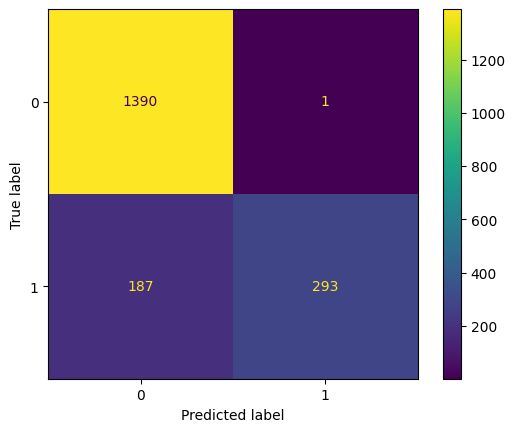

In [68]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import completeness_score
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,classification_report
# Create classifier.
clf = MultinomialNB()

# Fit the classifier on the training features and labels.
clf.fit(X_train, y_train)

# Make prediction - Store predictions in a list named pred.
pred = clf.predict(X_test)

#print(completeness_score(y_test,pred))
# Calculate the accuracy on the test data.
#print("Accuracy: {}".format(clf.score(X_test, y_test)))

accuracy_score(y_test,pred)
print(classification_report(y_test,pred))
ConfusionMatrixDisplay.from_estimator(clf,X_test,y_test);

# Naive Bayes works beter than below
***

In [61]:
from sklearn.cluster import KMeans

model = KMeans(random_state=0,algorithm='elkan')

model.fit(X_train,y_train)


KMeans(algorithm='elkan', random_state=0)

In [62]:
from sklearn.metrics import completeness_score
kmeans_pred = model.predict(X_test)
score = completeness_score(y_test,kmeans_pred)
print(score)

0.13791278485059735
